In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

# 1D Ising model

## Introduction

Consider the 1D Ising model of $N$ identical spins with the hamiltonian given by

$$ \mathcal{H}(\mathbf{s}) = -J \sum_{i=1}^N s_i s_{i+1} - H \sum_{i=1}^N s_i, $$

where $J$ is the coupling constant and $H$ is the external field. We impose periodic boundary conditions such that $s_{N+1} = s_1$. The probability distribution for the state $\mathbf{s}$ of the system is given by the Boltzmann distribution as

$$ p(\mathbf{s}) = \frac{1}{\mathcal{Z}}\exp\{-\mathcal{H}(\mathbf{s})\},$$

with the partition function defined by 

$$ \mathcal{Z} \equiv \sum_{\mathbf{s}} \exp\{-\mathcal{H}(\textbf{s})\}. $$

Note that we have chosen units such that $k_\text{B} T = 1$. We simulate the Ising model using the Metropolis-Hastings algorithm. The advantage of this approach is that it is not necessary to evaluate the partition function, which is computationally expensive.

The algorithm consists of taking a small time step $\text{d}t$, which we take to be constant for now (as opposed to a Gillespie simulation). During each time step, we perform two steps:

- starting in the state $\mathbf{s}$, sample one spin and flip it to reach a new state $\mathbf{s'}$
- accept the new state with probability 1 if $\mathcal{H}(\mathbf{s'}) < \mathcal{H}(\mathbf{s})$ and with probability $\rho(\mathbf{s'} | \mathbf{s}) \equiv p(\mathbf{s'})/p(\mathbf{s}) = \exp\{-[\mathcal{H}(\mathbf{s'}) - \mathcal{H}(\mathbf{s})]\}. $

Note that we may conveniently write the acceptance probability as 

$$ \rho(\mathbf{s'} | \mathbf{s}) = \text{min}\left(1, \exp\{-[\mathcal{H}(\mathbf{s'}) - \mathcal{H}(\mathbf{s})]\} \right). $$

Actually, since we only flip one spin at a time, the expression for $\mathcal{H}(\mathbf{s'}) - \mathcal{H}(\mathbf{s})$ can be simplified further, which would save some computational cost. For the sake of generality, we choose to implement it like this until performance actually becomes an issue.

In [2]:
def hamiltonian_1d(s,J,H):
    s_roll = np.roll(s,1)
    coupling = -J*np.sum(s*s_roll)
    field = -H*np.sum(s)
    return coupling + field

In [3]:
def metropolis_hastings(s0,J,H,n_sims):
    # number of spins
    n_spins = s0.size
    
    # count how many are accepted
    acceptance = 0
    
    # initialise
    s = np.zeros((n_sims, n_spins))
    s[0,:] = s0
    
    # repeat the flipping multiple times
    for i in range(1,n_sims):
        # randomly draw which spin to flip
        flip_idx = np.random.randint(n_spins)
        
        # flip a spin
        s_trial = np.copy(s[i-1,:])
        s_trial[flip_idx] *= -1
        
        # determine acceptance probability
        rho = np.min([1,np.exp(-(hamiltonian_1d(s_trial,J,H) - hamiltonian_1d(s[i-1,:],J,H)))])
        
        # apply acceptance-rejection criterion
        u = np.random.uniform(0,1)
        if u < rho:
            s[i,:] = s_trial
            acceptance += 1
        else:
            s[i,:] = s[i-1,:]
        
    return s, acceptance

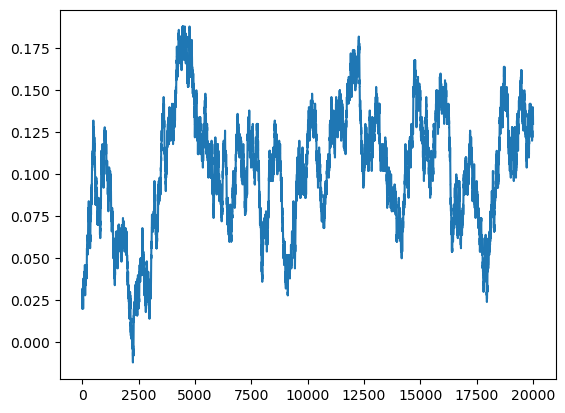

Acceptance rate: 0.8992


In [4]:
# here we verify that the algorithm works
s0 = np.random.choice([-1.,1.], 10**3)
n_sims = 2*10**4
J = 0
H = 0.1

# perform the algorithm
spins, acceptance = metropolis_hastings(s0,J,H,n_sims)

# extract average magnetisation
avg_act = np.mean(spins, axis=1)

plt.plot(np.arange(n_sims), avg_act)
plt.show()

print('Acceptance rate:', acceptance/n_sims)

## Case without coupling

The above suggests that we have implemented the 1D Ising model correctly, but we would like to verify this in more detail. Therefore, we consider the simplified case without coupling energy ($J=0$) and study the average activity once the system has equilibrated. This depends on the value of the external field $H$, where the theoretical result for the average activity per receptor $m$ in the case without coupling is

$$ m(H) = \tanh(H). $$

We verify this result as follows. For various values of $H$, we perform the Metropolis-Hastings algorithm sufficiently long for the system to equilibrate. We calculate the activity per receptor at each time and then remove the transient. From the remaining trajectory, we calculate the steady-state mean. Repeating this for various values of $H$ should then reveal the functional dependence of $m$ on $H$.

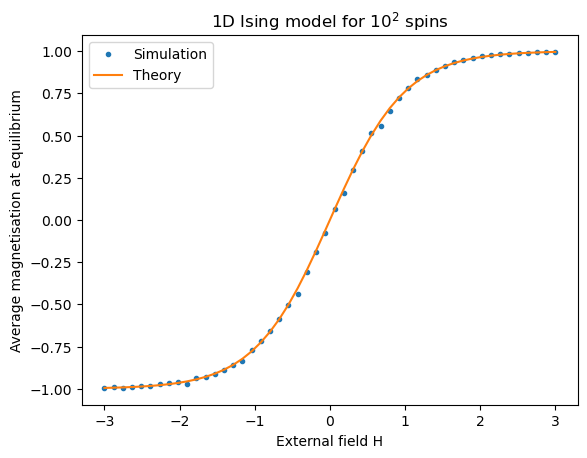

In [5]:
# initialise and parameters
s0 = np.random.choice([-1.,1.], 10**2)
n_sims = 10**4
J = 0

# values of H to loop over
H_arr = np.linspace(-3,3,50)
all_avg_act = np.zeros_like(H_arr)

# perform Metropolis-Hastings for various H
for i,H in enumerate(H_arr):
    spins, _ = metropolis_hastings(s0,J,H,n_sims)
    avg_act = np.mean(spins, axis=1)
    
    # truncate at half the simulation and take mean
    all_avg_act[i] = np.mean(avg_act[n_sims//2:])

# show results
plt.plot(H_arr, all_avg_act,'.', label='Simulation')
plt.plot(H_arr, np.tanh(H_arr), label='Theory')
plt.title(r'1D Ising model for $10^2$ spins')
plt.xlabel('External field H')
plt.ylabel('Average magnetisation at equilibrium')
plt.legend()
plt.show()

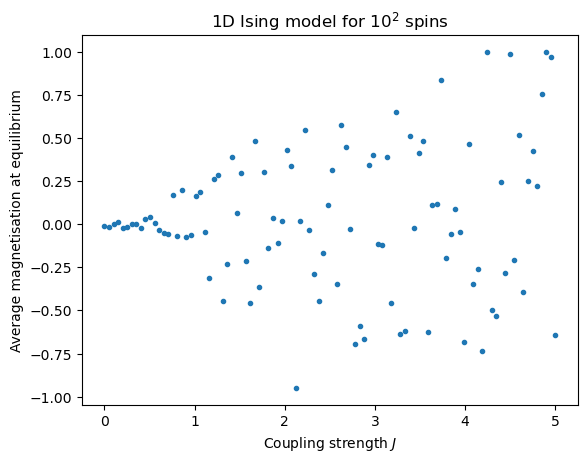

In [6]:
# initialise and parameters
s0 = np.random.choice([-1.,1.], 10**2)
n_sims = 10**4
H = 0

# values of J to loop over
J_arr = np.linspace(0,5,100)
all_avg_act = np.zeros_like(J_arr)

# perform Metropolis-Hastings for various J
for i,J in enumerate(J_arr):
    spins, _ = metropolis_hastings(s0,J,H,n_sims)
    avg_act = np.mean(spins, axis=1)
    
    # truncate at half the simulation and take mean
    all_avg_act[i] = np.mean(avg_act[n_sims//2:])

# show results
plt.plot(J_arr, all_avg_act,'.', label='Simulation')
plt.title(r'1D Ising model for $10^2$ spins')
plt.xlabel(r'Coupling strength $J$')
plt.ylabel('Average magnetisation at equilibrium')
plt.show()

## 2D Ising Model

Having simulated the 1D Ising model, we move on to the more applicable two-dimensional case. In general, the hamiltonian for a 2D Ising model is

$$ \mathcal{H}(\mathbf{s}) = -\sum_{(i,j)}J_{ij} s_i s_j - \sum_{i=1}^N H_i s_i $$

where $(i,j)$ denotes some pair of spins. In principle, these could be any two spins. Additionally, the coupling constant and external field could differ per spin or pair of spin. For our purposes, we can however make some simplifying assumptions. Firstly, we assume that the coupling constant and external field is independent of the spin, so $J_{ij} = J$ and $H_i = H$ for all $i,j = 1,...,N$. Secondly, for now we assume that the spins are arranged in a regular square lattice of size $N = L^2$ and that only nearest-neighbour interactions are relevant. 

Since we are dealing with a finite system, specifying the boundary conditions is important. For now, we assume an open boundary. This means that the spins in the bulk have four nearest neighbours, the spins on the side only three and the spins in the corners of the lattice only two. We expect that this choice of boundary condition becomes less relevant as the system size grows. 

We simulate the system in much the same way as in the 1D case. However, the computational cost of evaluating the hamiltonian is much higher in the 2D case, so we would like to go easy on the computer. For that, we find an expression for the energy difference $\mathcal{H}(\mathbf{s'}) - \mathcal{H}(\mathbf{s})$. Recall that $\mathbf{s'}$ and $\mathbf{s}$ differ only in the sign of one spin, say $s_k$. It is then straightforward to show that most terms in the energy difference cancel (i.e., those containing only spins that did not flip), such that the energy difference is

$$ \mathcal{H}(\mathbf{s'}) - \mathcal{H}(\mathbf{s}) = 2J s_k \sum_{(k,j)}s_j + 2 H s_k, $$

where $s_k$ is the value the spin had in $\mathbf{s}$. Note that we can take $s_k$ outside the summation since we are not summing over $k$, but only over those $j$ such that $s_k$ and $s_j$ are nearest neighbours. The first summation is over the nearest neighbours of $s_k$, which contains at most four terms, so the computation of the energy difference comes at the expense of evaluating at most five terms, which is much reduced compared to naively computing both hamiltonians and subtracting them afterwards. With this result at hand, we can start to implement the 2D Ising model.

**Problem**: the code for determining the coupling energy is clumsy but I don't know how to make it neater

In [47]:
def metropolis_hastings_2d(s0,J,H,n_sims):
    # number of spins
    n_spins = s0.size
    L = int(np.sqrt(n_spins))
    
    # count how many are accepted
    acceptance = 0
    
    # initialise
    s = np.zeros((n_sims, L, L))
    s[0,:, :] = s0
    
    # repeat the flipping multiple times
    for i in range(1,n_sims):
        # randomly draw which spin to flip
        k = np.random.randint(L)
        l = np.random.randint(L)
        
        # flip a spin
        s_trial = np.copy(s[i-1,:,:])
        s_trial[k,l] *= -1
        
        # energy difference due to external field
        delta_H_field = 2*H*s[i-1,k,l]
        
        # determine energy difference due to coupling based on where the spin is
        
        # top-left corner
        if k == 0 and l == 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k+1,l] + s_trial[k,l+1])
        # top-right corner
        elif k == 0 and l == L-1:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k+1,l] + s_trial[k,l-1])
        # bottom-left corner
        elif k == L-1 and l == 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k-1,l] + s_trial[k,l+1])
        # bottom-right corner
        elif k == L-1 and l == L-1:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k-1,l] + s_trial[k,l-1])
        # upper edge
        elif k == 0 and l % (L-1) != 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l-1] + s_trial[k,l+1] + s_trial[k+1,l])
        # lower edge
        elif k == L-1 and l % (L-1) != 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l-1] + s_trial[k,l+1] + s_trial[k-1,l])
        # left edge
        elif k % (L-1) != L-1 and l == 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l+1] + s_trial[k-1,l] + s_trial[k+1,l])
        # right edge
        elif k % (L-1) != L-1 and l == L-1:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l-1] + s_trial[k-1,l] + s_trial[k+1,l])
        # bulk    
        else:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k-1,l] + s_trial[k+1,l] + s_trial[k,l+1] + s_trial[k,l-1])
        
        # determine acceptance probability
        delta_H = delta_H_field + delta_H_coupling
        rho = np.min([1,np.exp(-delta_H)])
        
        # apply acceptance-rejection criterion
        u = np.random.uniform(0,1)
        if u < rho:
            s[i,:,:] = s_trial
            acceptance += 1
        else:
            s[i,:,:] = s[i-1,:,:]
        
    return s, acceptance

In [8]:
# check how fast this goes

# set initial lattice and parameters
L = 50
s0 = np.random.choice([-1.,1.], L**2)
s0 = s0.reshape((L,L))

n_sims = 10**4
J = 1
H = 1

# obtain results
%timeit metropolis_hastings_2d(s0,J,H,n_sims)

374 ms ± 6.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# set initial lattice and parameters
L = 100
s0 = np.random.choice([-1.,1.], L**2)
s0 = s0.reshape((L,L))

n_sims = 2*10**5
J = 10
H = 0

# obtain results
results, acceptance = metropolis_hastings_2d(s0,J,H,n_sims)

# show first and last state
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.imshow(results[0,:,:],cmap=plt.cm.gray)
ax1.set_title('Initial configuration')

ax2.imshow(results[-1,:,:],cmap=plt.cm.gray)
ax2.set_title('Final configuration')

plt.show()

# average magnetisation per spin
m = np.mean(results, axis=(1,2))

plt.plot(np.arange(n_sims), m)
plt.xlabel('Number of iterations')
plt.ylabel('Magnetisation per spin')
plt.show()

## Spontaneous magnetisation

A well-known property of the 2D Ising model is that it displays a continuous phase transition between ferro- and paramagnetism depending on the coupling strength $J$, even in the absence of an external field. For an infinite system, the critical point is found theoretically at

$$ J^* = \frac{1}{2}\log(1 + \sqrt{2}). $$

In finite systems, an exact result is not known. Yet, for a lattice with size $L^2$, an approximate result is available as

$$J^*_L \approx \frac{J^*}{1 - c/L}, $$

where $c$ is a constant that depends on the boundary conditions. For open boundaries, $c = 1.25$. In this section, we will verify whether our finite simulation approximates this result. For this purpose, we set $H=0$ throughout and simulate the model for various values of $J>0$ and compute the average magnetisation at equilibrium as described before in the 1D case. 

**Problem:** I do see well-defined domains if the coupling strength is high enough

Theoretical critical value for infinite system: J= 0.44068679350977147
Theoretical critical value for finite system: J= 0.4519864548818169


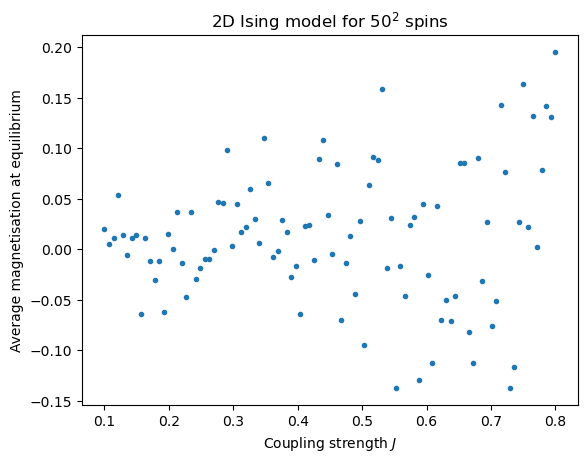

In [49]:
# set initial lattice and parameters
L = 50
s0 = np.random.choice([-1.,1.], L**2)
s0 = s0.reshape((L,L))

n_sims = 2*10**4
H = 0

# theoretical results
Jstar = 0.5*np.log(1+np.sqrt(2))
JstarL = Jstar/(1 - 1.25/L)

print('Theoretical critical value for infinite system: J=', Jstar)
print('Theoretical critical value for finite system: J=', JstarL)

# values of J to loop over
J_arr = np.linspace(0.1,0.8,10**2)
all_avg_act = np.zeros_like(J_arr)

# perform Metropolis-Hastings for various J
for i,J in enumerate(J_arr):
    spins, _ = metropolis_hastings_2d(s0,J,H,n_sims)
    avg_act = np.mean(spins, axis=(1,2))
    
    # truncate at half the simulation and take mean
    all_avg_act[i] = np.mean(avg_act[n_sims//2:])

# show results
plt.plot(J_arr, all_avg_act,'.', label='Simulation')
plt.title(r'2D Ising model for $50^2$ spins')
plt.xlabel(r'Coupling strength $J$')
plt.ylabel('Average magnetisation at equilibrium')
plt.show()

# 2D Ising Model with Time Evolution

The above simulations appear correct and are reasonably fast, but the underlying algorithm has a drawback. There is not really a good notion of time other than the number of simulations we perform, but this is a poor measure for how long the system gets stuck in a specific configuration. Therefore, we now seek a scheme that allows to study the time evolution of the Ising model. 

Fortunately, only minor changes are necessary to achieve this. Currently, once we have a candidate state $\mathbf{s'}$, we accept it with a certain probability. If we do not accept it, we choose a new trial state and repeat this process several times. A different approach is to insist that we change the state of the system at the end of each iteration, even though this means trying multiple times to accept the trial state. The number of attempts to change the state is then a measure of time. 

Concretely, given two possible states $\mathbf{s}$ and $\mathbf{s'}$, the probability of being in the latter (at equilibrium) follows from the Boltzmann distribution as

$$ \rho(\mathbf{s'}) = \frac{\exp\{-\mathcal{H}(\mathbf{s'})\}}{\exp\{-\mathcal{H}(\mathbf{s'})\} + \exp\{-\mathcal{H}(\mathbf{s})\}} = \frac{1}{1 + \exp\{\Delta \mathcal{H} \}}, $$

where $\Delta \mathcal{H} \equiv \mathcal{H}(\mathbf{s'}) - \mathcal{H}(\mathbf{s}).$ With this in mind, we perform the following algorithm:

- starting in the state $\mathbf{s}$, sample one spin and flip it to reach a new state $\mathbf{s'}$
- compute the probability of being in $\mathbf{s'}$ as opposed to $\mathbf{s}$ as $\rho(\mathbf{s'})$
- sample a uniform random number $u$ between 0 and 1:
    - if $u < \rho(\mathbf{s'})$, change the system's state to $\mathbf{s'}$
    - else, sample a new $u$ and repeat the previous step
    - update time as $N_{\text{rep}} \text{d}t$, where $N_{\text{rep}}$ is the number of attempts necessary to accept $\mathbf{s'}$

Repeating these steps multiple times then simulates the Ising model. Note that we pick an intrinsic time $\text{d}t$ that is a measure for how long it takes to flip a spin. 
    

In [24]:
def ising_2d_time(s0,J,H,n_sims,dt):
    # number of spins
    n_spins = s0.size
    L = int(np.sqrt(n_spins))
    
    # initialise
    s = np.zeros((n_sims, L, L))
    s[0,:, :] = s0
    
    # store waiting times
    waiting_times = np.zeros(n_sims)
    
    # repeat the flipping multiple times
    for i in range(1,n_sims):
        # randomly draw which spin to flip
        k = np.random.randint(L)
        l = np.random.randint(L)
        
        # flip a spin
        s_trial = np.copy(s[i-1,:,:])
        s_trial[k,l] *= -1
        
        # energy difference due to external field
        delta_H_field = 2*H*s[i-1,k,l]
        
        # determine energy difference due to coupling based on where the spin is
        
        # top-left corner
        if k == 0 and l == 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k+1,l] + s_trial[k,l+1])
        # top-right corner
        elif k == 0 and l == L-1:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k+1,l] + s_trial[k,l-1])
        # bottom-left corner
        elif k == L-1 and l == 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k-1,l] + s_trial[k,l+1])
        # bottom-right corner
        elif k == L-1 and l == L-1:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k-1,l] + s_trial[k,l-1])
        # upper edge
        elif k == 0 and l % (L-1) != 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l-1] + s_trial[k,l+1] + s_trial[k+1,l])
        # lower edge
        elif k == L-1 and l % (L-1) != 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l-1] + s_trial[k,l+1] + s_trial[k-1,l])
        # left edge
        elif k % (L-1) != L-1 and l == 0:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l+1] + s_trial[k-1,l] + s_trial[k+1,l])
        # right edge
        elif k % (L-1) != L-1 and l == L-1:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k,l-1] + s_trial[k-1,l] + s_trial[k+1,l])
        # bulk    
        else:
            delta_H_coupling = 2*J*s[i-1,k,l]*(s_trial[k-1,l] + s_trial[k+1,l] + s_trial[k,l+1] + s_trial[k,l-1])
        
        # determine acceptance probability
        delta_H = delta_H_field + delta_H_coupling
        rho = 1/(1 + np.exp(delta_H))
        
        u = np.random.uniform(0,1)
        if u < rho:
            s[i,:,:] = s_trial
        else:
            s[i,:,:] = s[i-1,:,:]
        
        # keep track of how long it takes to flip
        #time_since_flip = 0
        
        # wait until the trial state is accepted
        #accepted = False
        
        #while accepted == False:
        #    u = np.random.uniform(0,1)
        #    time_since_flip += dt
            
            # acceptance
        #    if u < rho:
        #        s[i,:,:] = s_trial
        #        accepted = True
        
        # store waiting time
        #waiting_times[i] = time_since_flip
        
    return s

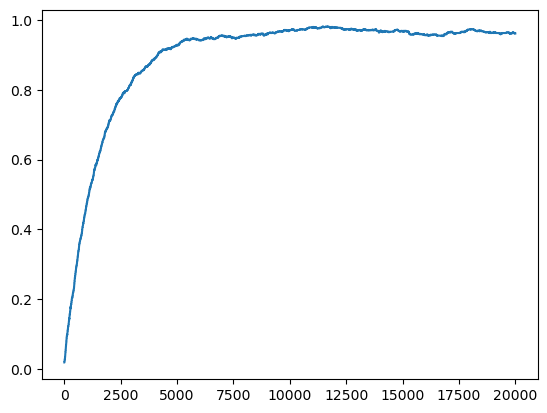

In [42]:
# set initial lattice and parameters
L = 40
s0 = np.random.choice([-1.,1.], L**2)
s0 = s0.reshape((L,L))

dt = 1
n_sims = 2*10**4
J = 0
H = 2

spins = ising_2d_time(s0,J,H,n_sims,dt)

avg_act = np.mean(spins, axis=(1,2))
time = np.cumsum(waiting_times)

plt.plot(np.arange(0,n_sims), avg_act)
plt.show()